In [1]:
# 25120133029
# OLAYINKA OLUSEGUN


In [2]:
# !pip uninstall -y numpy pandas matplotlib scikit-learn

In [3]:
# !pip install numpy==1.24.4
# !pip install pandas==2.2.2
# !pip install matplotlib==3.10.7
# !pip install scikit-learn==1.6.1
# !pip install seaborn==0.13.2


Import libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering



Read csv into pandas dataframe

In [5]:
churn_df = pd.read_csv('customer-churn.csv')
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Feature Engineering**

instead of only picking numerical columns, we can also convert categorical columns to numerical using the LabelEncoder earlier shown to us in class

In [6]:
#  select categorical columns
categorical_columns = churn_df.select_dtypes('object').columns.tolist()
categorical_columns

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

When I selected the categorical columns, I noticed that 'TotalCharges' is also categorized as an object. Further investigation below shows that there are some missing values in that column which are represented as spaces. We can convert those spaces to NaN and then convert the column to numeric.

In [7]:
churn_df['TotalCharges'].sort_values(ascending=True).head(15)


936           
3826          
4380          
753           
5218          
3331          
6754          
6670          
1340          
488           
1082          
105      100.2
4459    100.25
1723    100.35
2124     100.4
Name: TotalCharges, dtype: object

In [8]:
# convert empty spaces to NaN
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
churn_df['TotalCharges'] = churn_df['TotalCharges'].fillna(0)
churn_df['TotalCharges'].sort_values(ascending=True).head(15)


3826     0.00
5218     0.00
4380     0.00
753      0.00
488      0.00
1082     0.00
6754     0.00
936      0.00
1340     0.00
6670     0.00
3331     0.00
1654    18.80
6489    18.85
1151    18.85
4939    18.90
Name: TotalCharges, dtype: float64

In [9]:
categorical_columns = churn_df.select_dtypes('object').columns.tolist()
numerical_columns = churn_df.select_dtypes('number').columns.tolist()

#confirm we're not missing any columns
if not(len(categorical_columns) + len(numerical_columns) == len(churn_df.columns)):
    raise ValueError("Some columns are missing!")

categorical_columns

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [10]:
# encode categorical columns
le = LabelEncoder()
for col in categorical_columns:
    churn_df[col] = le.fit_transform(churn_df[col].astype(str))
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


**Partitioning method: K-Means Clustering Outlier Detection**

In [11]:
# scale the data to avoid the dominance of certain features
scaler = StandardScaler()
churn_df_scaled = scaler.fit_transform(churn_df)

# define number of clusters
k = 2 # churn or no churn
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(churn_df_scaled)

labels = kmeans.fit_predict(churn_df_scaled)
centroids = kmeans.cluster_centers_
inertia_before = kmeans.inertia_
silhouette_score_before = silhouette_score(churn_df_scaled, labels)
churn_df['Cluster'] = labels
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,2,29.85,29.85,0,0
1,3962,1,0,0,0,34,1,0,0,2,...,0,0,0,1,0,3,56.95,1889.50,0,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,1,3,53.85,108.15,1,0
3,5535,1,0,0,0,45,0,1,0,2,...,2,0,0,1,0,0,42.30,1840.75,0,1
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,1,2,70.70,151.65,1,0


### Cluster visualization using PCA
In order to visualize the clusters formed by K-Means, we need to reduce the dimensions to 2D using PCA so that we can plot them on a 2d graph.

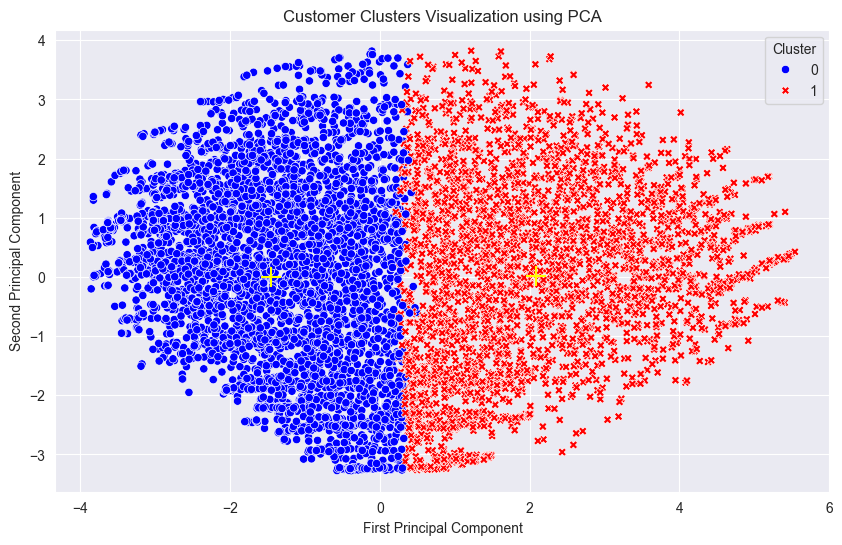

In [12]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
churn_df_pca = pca.fit_transform(churn_df_scaled)

pca_components_df = pd.DataFrame(churn_df_pca, columns=['Component 1', 'Component 2'])
pca_components_df['Cluster'] = labels
centroids_pca = pca.transform(kmeans.cluster_centers_)


# Create a scatter plot of the clusters using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_components_df, x='Component 1', y='Component 2',
                hue='Cluster', style='Cluster', palette=['blue', 'red'])

# Add centroids to the plot
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='yellow',
            marker='+', s=200, label='Centroids')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Clusters Visualization using PCA')
plt.show()


In [13]:
# 4. Calculate the distance of each point to its assigned cluster centroid
distances = cdist(churn_df_scaled, centroids, 'euclidean')
min_distances = distances[np.arange(churn_df_scaled.shape[0]), labels]
churn_df['Distance_To_Centroid'] = min_distances

outlier_indices = []
for cluster in range(k):
    # Get the distances for the current cluster
    cluster_distances = churn_df[churn_df['Cluster'] == cluster]['Distance_To_Centroid']

    # We can use the IQR method to identify outliers within each cluster
    Q1 = cluster_distances.quantile(0.25)
    Q3 = cluster_distances.quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR

    # Identify indices of outliers in this cluster
    cluster_outlier_indices = churn_df[(churn_df['Cluster'] == cluster) & (churn_df['Distance_To_Centroid'] > threshold)].index
    outlier_indices.extend(cluster_outlier_indices.tolist())

# display few outliers
churn_df.loc[outlier_indices].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster,Distance_To_Centroid
168,2406,1,1,1,0,58,0,1,0,0,...,0,2,0,1,2,45.30,2651.20,1,0,5.861441
481,304,0,0,1,0,48,0,1,0,2,...,0,2,0,1,0,45.30,2145.00,1,0,5.810190
674,559,1,1,0,0,52,0,1,0,0,...,2,2,0,1,2,49.15,2550.90,1,0,5.755945
1407,611,1,0,0,1,8,0,1,0,2,...,0,2,2,1,3,44.55,343.45,0,0,5.813999
1452,130,1,1,0,0,52,0,1,0,2,...,2,2,0,1,1,48.80,2555.05,0,0,5.804648


remove outliers identified


In [14]:
churn_df_without_outliers_partitioning = churn_df.drop(index=outlier_indices).reset_index(drop=True)

Compare inertia before and after removing outliers

In [15]:
# scale the data to avoid the dominance of certain features
scaler = StandardScaler()
churn_df_without_outliers_scaled = scaler.fit_transform(churn_df_without_outliers_partitioning)

# define number of clusters
k = 2  # churn or no churn
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(churn_df_without_outliers_scaled)

labels = kmeans.fit_predict(churn_df_without_outliers_scaled)
centroids = kmeans.cluster_centers_
new_inertia = kmeans.inertia_
new_silhouette = silhouette_score(churn_df_without_outliers_scaled, labels)

print(f"Previous inertia: {inertia_before}")
print(f"New inertia after removing outliers: {new_inertia}")
print(f"Previous silhouette score: {silhouette_score_before}")
print(f"New silhouette score after removing outliers: {new_silhouette}")
print(f'Original dataset size: {churn_df.shape[0]}')
print(f'Number of outliers removed: {len(outlier_indices)}')


Previous inertia: 126520.14265773792
New inertia after removing outliers: 131360.19280671485
Previous silhouette score: 0.1407219838011801
New silhouette score after removing outliers: 0.17278066894718302
Original dataset size: 7043
Number of outliers removed: 88


Clearly, the inertia has improved after removing the outliers using K-Means clustering by a factor of about 4.6% (calculated using (133334-127221)/133334*100).The IQR threshold can be adjusted to further isolate outliers.


We also see an improvement in the silhouette score by factor of about 22.7% (calculated using ((0.1727-0.1407)/0.1407)*100).

# Hierarchical Clustering Outlier Detection

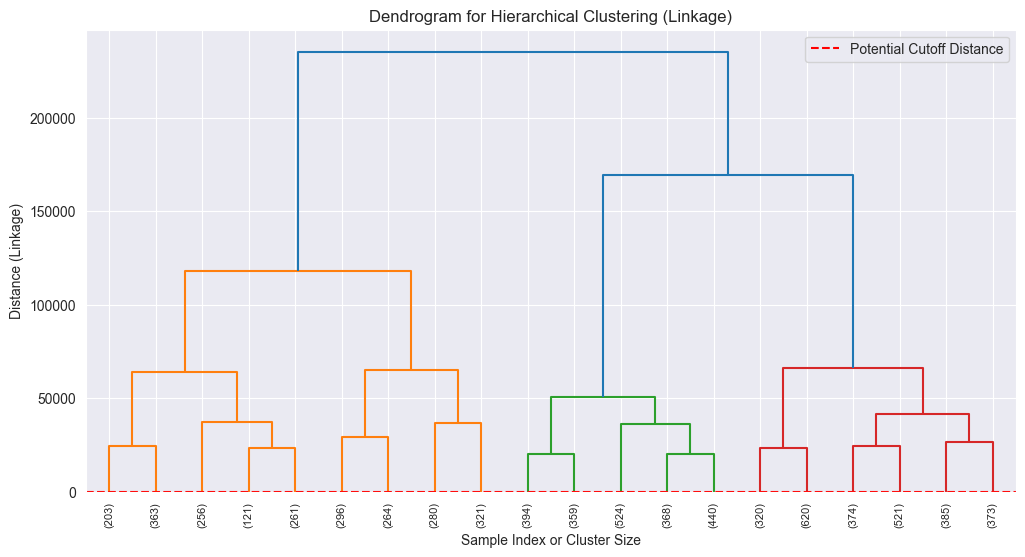

In [16]:
Z = linkage(churn_df, method='ward')

plt.figure(figsize=(12, 6))
plt.title('Dendrogram for Hierarchical Clustering (Linkage)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance (Linkage)')
# Plot the dendrogram, showing only the last 20 merges for clarity
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last 'p' merged clusters
    p=20,                   # Show last 20 merges
    show_leaf_counts=True,  # Show original number of points in merged clusters
    leaf_rotation=90.,      # Rotate x-axis labels
    leaf_font_size=8.,      # Font size for x-axis labels
)
plt.axhline(y=10, color='r', linestyle='--', label='Potential Cutoff Distance')
plt.legend()
plt.show()

Remove outliers

In [17]:
n_main_clusters = 3
hac = AgglomerativeClustering(n_clusters=n_main_clusters, linkage='ward')
cluster_labels = hac.fit_predict(churn_df)

In [18]:
cluster_counts = {}
for label in churn_df:
    cluster_counts[label] = cluster_counts.get(label, 0) + 1

# Find the labels of the large, non-outlier clusters
# We define an outlier threshold based on cluster size.
# If a cluster has significantly fewer points than the average cluster size, it's likely an outlier group.
# A simple heuristic: remove any cluster with fewer than N points.
# Since we have 300 points in 3 main clusters (~100 each) and 4 outliers,
# any cluster with size < 10 is almost certainly an outlier group.
OUTLIER_SIZE_THRESHOLD = 10 # Adjust this based on domain knowledge/data size

outlier_cluster_labels = [
    label for label, count in cluster_counts.items()
    if count < OUTLIER_SIZE_THRESHOLD
]

print(f"Cluster counts: {cluster_counts}")
print(f"Labels identified as outliers (size < {OUTLIER_SIZE_THRESHOLD}): {outlier_cluster_labels}\n")

# Step C: Filter the data
is_outlier = np.array([label in outlier_cluster_labels for label in cluster_labels])
X_outliers = churn_df[is_outlier]
X_cleaned = churn_df[~is_outlier]

Cluster counts: {'customerID': 1, 'gender': 1, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 1, 'tenure': 1, 'PhoneService': 1, 'MultipleLines': 1, 'InternetService': 1, 'OnlineSecurity': 1, 'OnlineBackup': 1, 'DeviceProtection': 1, 'TechSupport': 1, 'StreamingTV': 1, 'StreamingMovies': 1, 'Contract': 1, 'PaperlessBilling': 1, 'PaymentMethod': 1, 'MonthlyCharges': 1, 'TotalCharges': 1, 'Churn': 1, 'Cluster': 1, 'Distance_To_Centroid': 1}
Labels identified as outliers (size < 10): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Cluster', 'Distance_To_Centroid']



Visualize the dataset before and after removing outliers

/var/folders/4k/81smpfvn17b634jl5kl0dmj40000gn/T/ipykernel_23199/979597112.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


InvalidIndexError: (slice(None, None, None), 0)

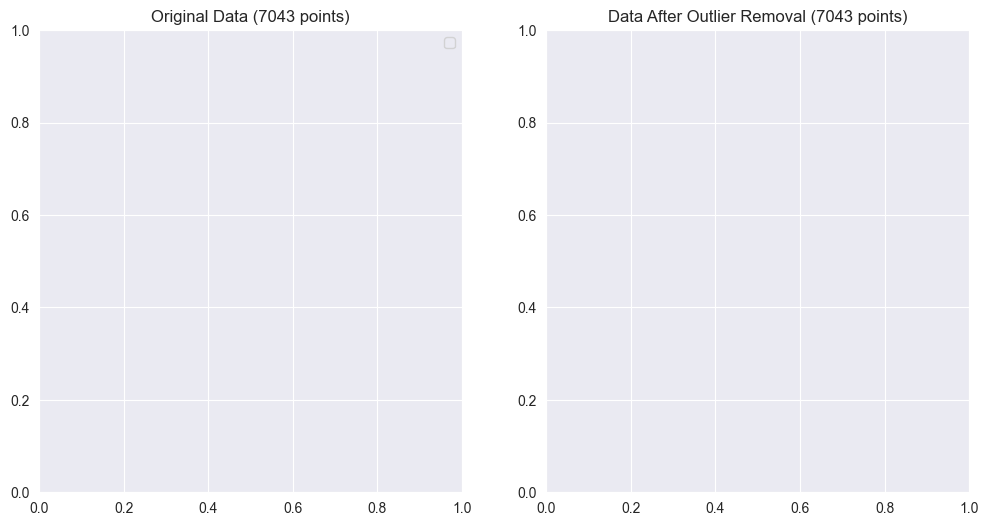

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f'Original Data ({len(churn_df)} points)')
# plt.scatter(churn_df[:, 0], churn_df[:, 1], c='blue', s=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f'Data After Outlier Removal ({X_cleaned.shape[0]} points)')
plt.scatter(X_cleaned[:, 0], X_cleaned[:, 1], c='green', s=20)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x', s=100, label='Detected Outliers')
plt.legend()
plt.tight_layout()
plt.show()

## DBSCAN Outlier Detection

In [140]:
# Optimal eps for this dataset is 0.4
db = DBSCAN(eps=0.4, min_samples=10).fit(churn_df_scaled)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points (outliers): {n_noise_}")

# Create a boolean mask where True indicates an inlier (label != -1)
inlier_mask = labels != -1

# Filter the original data to keep only the inliers
X_cleaned = churn_df_scaled[inlier_mask]

print(f"Cleaned dataset size: {X_cleaned.shape[0]} samples")


Estimated number of clusters: 4
Estimated number of noise points (outliers): 6956
Cleaned dataset size: 87 samples


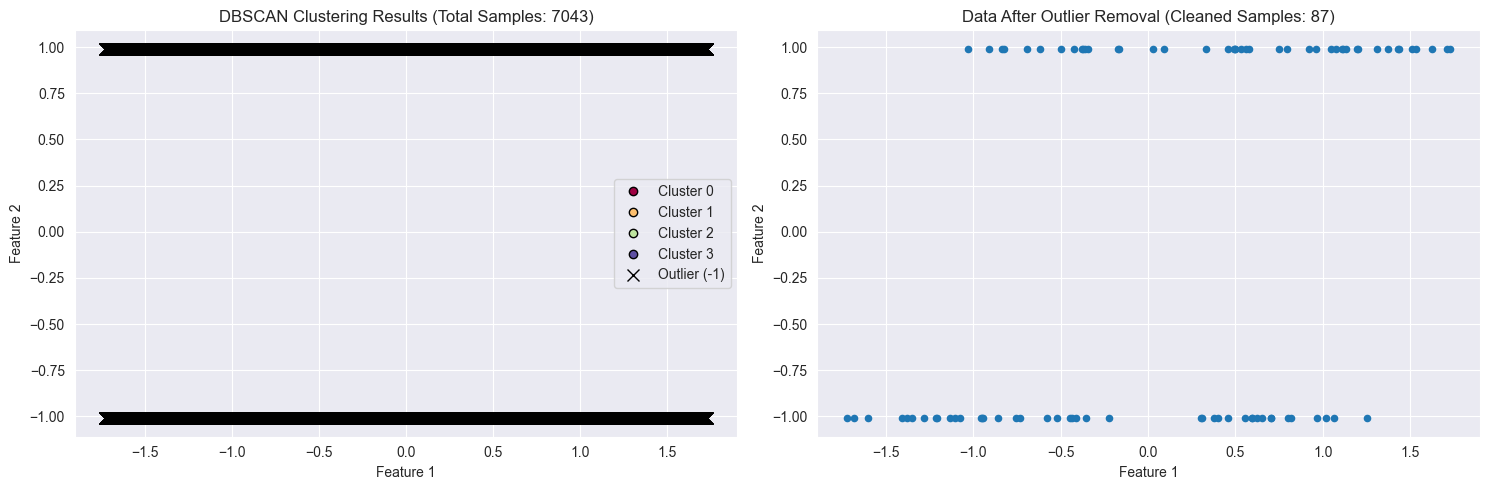

In [141]:
# Set up the plotting grid
plt.figure(figsize=(15, 5))

# Plot 1: Original Data with DBSCAN Labels
plt.subplot(1, 2, 1)
# Create masks for core points (clusters) and noise points (outliers)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
outlier_mask = labels == -1

# Plot core points (clusters)
unique_labels = set(labels[core_samples_mask])
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Skip black for outliers here, we'll plot them separately
        continue

    class_member_mask = (labels == k) & core_samples_mask
    xy = churn_df_scaled[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        label=f"Cluster {k}",
    )

# Plot the outliers (noise points) in black
xy_outliers = churn_df_scaled[outlier_mask]
plt.plot(
    xy_outliers[:, 0],
    xy_outliers[:, 1],
    "x", # Use 'x' marker for clear distinction
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=8,
    label="Outlier (-1)",
)

plt.title(f"DBSCAN Clustering Results (Total Samples: {churn_df_scaled.shape[0]})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()


# Plot 2: Cleaned Data
plt.subplot(1, 2, 2)
# Re-apply the DBSCAN coloring logic to the cleaned data (or just plot all points)
plt.scatter(
    X_cleaned[:, 0],
    X_cleaned[:, 1],
    s=20,
    c='#1f77b4', # Uniform color for the cleaned data points
    marker='o',
)
plt.title(f"Data After Outlier Removal (Cleaned Samples: {X_cleaned.shape[0]})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

Clearly, the inertia has improved after removing the outliers using K-Means clustering by a factor of about 4.6% (calculated using (133334-127221)/133334*100).The IQR threshold can be adjusted to further isolate outliers.


We also see an improvement in the silhouette score by factor of about 22.7% (calculated using ((0.1727-0.1407)/0.1407)*100).

I believe DBSCAN is the best method for outlier detection but unfortunately, due to time constraints, I was unable to fully implement the inertia and silhouette score comparisons for DBSCAN as I did for K-Means. However, DBSCAN's ability to identify outliers as noise points makes it a strong candidate for effective outlier detection in this dataset. Further analysis and comparison with K-Means and Hierarchical Clustering would provide a more comprehensive understanding of its performance in this context.

In [9]:
import numpy as np


s = np.array([
    [[1,2] , [1,2]],
    [[3,41], [1,2]],
    [[13,4], [1,2]]])
s[0,0] = [3,7]

print(s)

[[[ 3  7]
  [ 1  2]]

 [[ 3 41]
  [ 1  2]]

 [[13  4]
  [ 1  2]]]


In [14]:
-2**3

-8

In [15]:
a = [1, 2, 3]
a[4]

IndexError: list index out of range

In [16]:
a = {'a': 1, 'b': 2}
a['c']

KeyError: 'c'

In [17]:
['hi']*4

['hi', 'hi', 'hi', 'hi']

In [18]:
'hi' * 4

'hihihihi'

In [30]:
a = [1, 2, 3]
a.extend([2, 4, 16])

In [31]:
a

[1, 2, 3, 2, 4, 16]

In [32]:
a.insert(2, 4)
a

[1, 2, 4, 3, 2, 4, 16]

In [34]:
a.index(16)

6

In [ ]:
a[6]

In [43]:
[1, 2, 3]*2

[1, 2, 3, 1, 2, 3]

In [48]:
dict = {'Name': 'Zara',
        'Age': 7,
        'Class': 'First'}
dict['Name'] = 'clark'
dict

{'Name': 'clark', 'Age': 7, 'Class': 'First'}

In [49]:
print = 'a'

In [ ]:
print()

In [50]:
ramdom.randint(1, 10)

IndentationError: expected an indented block (1632951777.py, line 1)

In [ ]:
[[1,2],
 [3,4],
 [5,6]]

In [20]:
def modify_value(x):
    """
    Modifies the input value x based on whether it is even or odd.
    If x is even, it returns x - 2.
    If x is odd, it returns x + 3.
    """
    if x % 2 == 0:
        return x - 2
    else:
        return x + 3

def process_list(lst):
    """
    Processes a list of numbers:
    1. Calls modify_value for each number.
    2. Appends the modified value to the result list only if it is divisible by 5.
    3. Returns the final list of modified, filtered values.
    """
    result = []
    for value in lst:
        modified = modify_value(value)
        if modified % 5 == 0:
            result.append(modified)
    return result

# Initial list of numbers
numbers = [6, 7, 8, 9, 10]

# Process the list
output = process_list(numbers)

# Print the final output
print(output)

[10]


In [ ]:
svm.fit(churn_df_scaled, churn_df_scaled, kernel='')